In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import io
import re
import subprocess
import html
from datetime import datetime

In [37]:
def get_note_content(note_title):
    # Define the AppleScript command
    apple_script = f'''
    tell application "Notes"
        try
            set targetNote to first note whose name is "{note_title}"
            set theContent to the body of targetNote
            return theContent
        on error
            return "ERROR: Note named '{note_title}' not found."
        end try
    end tell
    '''

    try:
        # Execute the AppleScript
        process = subprocess.Popen(
            ['osascript', '-'],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        stdout, stderr = process.communicate(apple_script)

        if process.returncode != 0:
            print(f"AppleScript Error: {stderr.strip()}")
            return None

        if stdout.startswith("ERROR:"):
            print(stdout.strip())
            return None

        # Apple Notes may return the body in rich text (HTML). Convert it to plain text.
        plain_text = convert_html_to_text(stdout)
        return plain_text

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def convert_html_to_text(html_content):
    # Remove HTML tags using regex
    text = re.sub('<[^<]+?>', '', html_content)
    # Unescape HTML entities
    text = html.unescape(text)
    return text

note_title = "Temperature Log"
raw_data = get_note_content(note_title)

In [11]:
# Initialize lists to hold parsed data
dates = []
temperatures_c = []
humidities = []

# Split the raw data into lines and process each line
for line in raw_data.strip().split('\n'):
    # Skip header lines
    if line.startswith("Temperature Log") or line.startswith("Date,"):
        continue
    # Use regex to extract components
    match = re.match(r'(.+?)\s*:\s*([\d.]+)°C,\s*(\d+)', line)
    if match:
        date_str, temp_c, humidity = match.groups()
        dates.append(date_str.strip())
        temperatures_c.append(float(temp_c))
        humidities.append(int(humidity))
    else:
        print(f"Line skipped due to unmatched format: {line}")

# Create a DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Temperature_C': temperatures_c,
    'Humidity': humidities
})

In [12]:
# Define a function to parse the date strings
def parse_date(date_str):
    # Replace non-breaking space characters with regular space
    date_str = date_str.replace('\u202f', ' ')
    return datetime.strptime(date_str, '%b %d, %Y at %I:%M %p')

# Apply the function to the 'Date' column
df['Datetime'] = df['Date'].apply(parse_date)

In [13]:
# Define a function to convert Celsius to Fahrenheit
def c_to_f(celsius):
    return celsius * 9/5 + 32

# Apply the conversion
df['Temperature_F'] = df['Temperature_C'].apply(c_to_f)

In [14]:
df.set_index('Datetime', inplace=True)

In [16]:
nHot = 3
nCold = 3
hottest = df.nlargest(nHot, 'Temperature_C')
coldest = df.nsmallest(nCold, 'Temperature_C')

print(f"Top {nHot} Hottest Temperatures:")
for i, row in hottest.iterrows():
    date_obj = datetime.strptime(row['Date'], "%b %d, %Y at %I:%M %p")  # Convert string to datetime
    date_str = date_obj.strftime("%b %d, %Y at %I:%M %p")  # Format date properly
    print(f"{date_str}: {row['Temperature_F']:04.1f}°F, {row['Humidity']:02d}%")

print(f"\nTop {nCold} Coldest Temperatures:")
for i, row in coldest.iterrows():
    date_obj = datetime.strptime(row['Date'], "%b %d, %Y at %I:%M %p")  # Convert string to datetime
    date_str = date_obj.strftime("%b %d, %Y at %I:%M %p")  # Format date properly
    print(f"{date_str}: {row['Temperature_F']:04.1f}°F, {row['Humidity']:02d}%")

Top 3 Hottest Temperatures:
Feb 09, 2025 at 12:30 AM: 80.4°F, 15%
Feb 09, 2025 at 12:00 AM: 80.1°F, 15%
Feb 08, 2025 at 11:30 PM: 79.9°F, 15%

Top 3 Coldest Temperatures:
Feb 17, 2025 at 09:00 AM: 63.9°F, 13%
Feb 09, 2025 at 12:30 PM: 64.9°F, 18%
Feb 09, 2025 at 12:00 PM: 65.1°F, 17%


In [35]:
mean_temp = df['Temperature_F'].mean()
std_temp = df['Temperature_F'].std()

mean_humidity = df['Humidity'].mean()
std_humidity = df['Humidity'].std()

print(f"Mean Temperature: {mean_temp:.2f}°C, Std Deviation: {std_temp:.2f}°C")
print(f"Mean Humidity: {mean_humidity:.2f}%, Std Deviation: {std_humidity:.2f}%")
print()
print(f"Temperature bounds: {mean_temp - std_temp:.2f}°C to {mean_temp + std_temp:.2f}°C")
print(f"Humidity bounds: {mean_humidity - std_humidity:.2f}% to {mean_humidity + std_humidity:.2f}%")

Mean Temperature: 74.19°C, Std Deviation: 2.54°C
Mean Humidity: 15.94%, Std Deviation: 4.19%

Temperature bounds: 71.66°C to 76.73°C
Humidity bounds: 11.75% to 20.13%


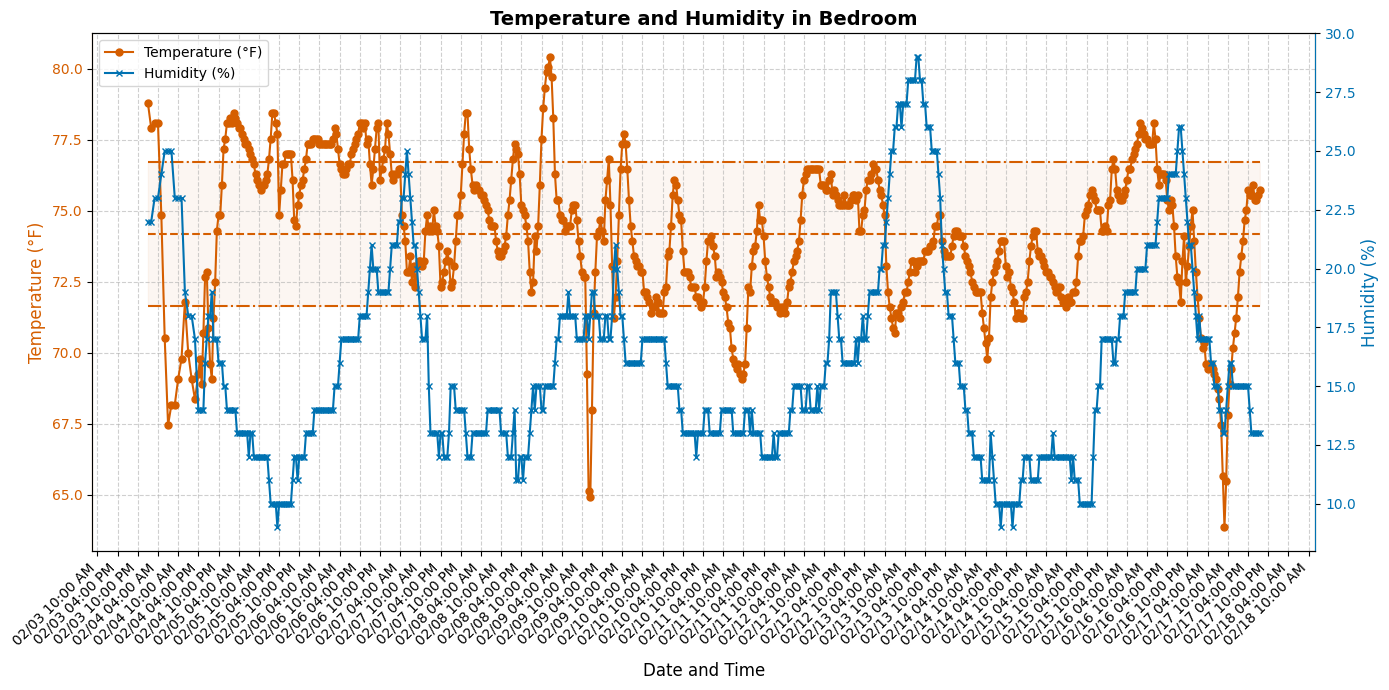

In [ ]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Temperature on the primary y-axis
color_temp = '#D55E00'  # Strong orange
ax1.set_xlabel('Date and Time', fontsize=12, labelpad=10)
ax1.set_ylabel('Temperature (°F)', color=color_temp, fontsize=12)
ax1.plot(df.index, df['Temperature_F'], color=color_temp, marker='o', linestyle='-', markersize=5, linewidth=1.5, label='Temperature (°F)')
ax1.tick_params(axis='y', labelcolor=color_temp)
ax1.spines['left'].set_color(color_temp)
ax1.hlines(mean_temp, df.index[0], df.index[-1], linestyles='--', colors=color_temp)#, label='Mean')
ax1.hlines([mean_temp + std_temp, mean_temp - std_temp], df.index[0], df.index[-1], linestyles='-.', colors=color_temp)#, label='Mean ± 1 Std Dev')
ax1.fill_between(df.index, mean_temp - std_temp, mean_temp + std_temp, color=color_temp, alpha=0.05)

# Create a secondary y-axis for Humidity
ax2 = ax1.twinx()
color_humidity = '#0072B2'  # Deep blue
ax2.set_ylabel('Humidity (%)', color=color_humidity, fontsize=12)
ax2.plot(df.index, df['Humidity'], color=color_humidity, marker='x', linestyle='-', markersize=5, linewidth=1.5, label='Humidity (%)')
ax2.tick_params(axis='y', labelcolor=color_humidity)
ax2.spines['right'].set_color(color_humidity)
# ax2.hlines(mean_humidity, df.index[0], df.index[-1], linestyles='--', colors=color_humidity)#, label='Mean')
# ax2.hlines([mean_humidity + std_humidity, mean_humidity - std_humidity], df.index[0], df.index[-1], linestyles='-.', colors=color_humidity)#, label='Mean ± 1 Std Dev')
# ax2.fill_between(df.index, mean_humidity - std_humidity, mean_humidity + std_humidity, color=color_humidity, alpha=0.05)

# Improve x-axis formatting
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %I:%M %p'))
locator = mdates.HourLocator(interval=6)  # Reduce clutter
ax1.xaxis.set_major_locator(locator)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)

# Add grid with better styling
ax1.grid(True, linestyle='--', alpha=0.6)

# Add a title
plt.title('Temperature and Humidity in Bedroom', fontsize=14, fontweight='bold')

# Add a combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10, frameon=True)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()